In [0]:
#%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

# 過去データの入手

In [127]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [128]:
# csvの読み込み kickstarter:二値分類, Car_Consum:線形回帰
df_kstart = pd.read_csv("gdrive/My Drive/DeepLearning/ai_zemi/kadai/data/ks-projects-201801.csv", encoding="utf-8")
#df_kstart = pd.read_csv("data/ks-projects-201801.csv", encoding="utf-8")

display(df_kstart.head())
display(df_kstart["state"].value_counts())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

# 基礎集計、グラフ化

*   ID: internal kickstarter id
*   name: name of project - A project is a finite work with a clear goal that you’d like to bring to life. Think albums, books, or films.
*   category: category
*   main_category: category of campaign
*   currency: currency used to support
*   deadline: deadline for crowdfunding
*   goal: fundraising goal - The funding goal is the amount of money that a creator needs to complete their project.
*   launched: date launched
*   pledged: amount pledged by "crowd"
*   state: Current condition the project is in
*   backers: number of backers
*   country: country pledged from
*   usd pledged: amount of money pledged
*   usd_goal_real: Goal amount in USD

## データ成形
**ID**, **name** は固有値なので除外<br>
**pledged**, **usdpledged**, **usd_pledged_real** は結果なので除外<br>
**period** = **deadline** - **launched** を追加する (day)<br>
今回は成功失敗の二項分類なので **state**.successful, failed 以外は除く

In [0]:
def preprocess(df):
  # success, failed の行のみ適用する
  df = df[(df["state"] == "successful") | (df["state"] == "failed")]
  # 開催期間を説明変数に加える
  df["deadline"] = pd.to_datetime(df["deadline"], errors = "coerce")
  df["launched"] = pd.to_datetime(df["launched"], errors = "coerce")
  period = df["deadline"] - df["launched"]
  df["period"] = period.dt.days + (period.dt.seconds / 86400)
  # 不要な説明変数(固有値/結果)を除く
  df = df.drop(columns=["ID", "name", "pledged", "usd pledged", "usd_pledged_real"])
  
  return df

In [134]:
df_kstart = preprocess(df_kstart)
df_kstart.replace({'successful': 1, "failed": 0}, inplace=True)
df_kstart["state"] = df_kstart["state"].astype("uint8")
display(df_kstart.head())
df_kstart.info()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

,category,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real,period
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0,0,GB,1533.95,58.491343
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,0,15,US,30000.00,59.802813
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,0,3,US,45000.00,44.985532
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,0,1,US,5000.00,29.858206
5,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,1,224,US,50000.00,34.431632


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 11 columns):
category         331675 non-null object
main_category    331675 non-null object
currency         331675 non-null object
deadline         331675 non-null datetime64[ns]
goal             331675 non-null float64
launched         331675 non-null datetime64[ns]
state            331675 non-null uint8
backers          331675 non-null int64
country          331675 non-null object
usd_goal_real    331675 non-null float64
period           331675 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(1), object(4), uint8(1)
memory usage: 28.2+ MB


[goal], [usd_goal_real]の相関係数が高いので、どちらかは除外してもいいかもしれない
[backers], [period] は目的変数に相関がありそう



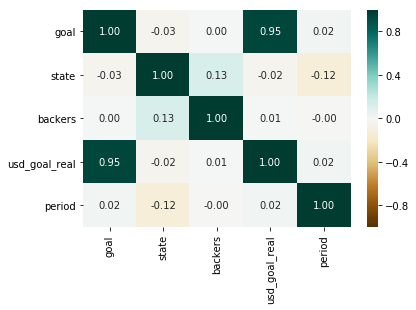

In [138]:
print("[goal], [usd_goal_real]の相関係数が高いので、どちらかは除外してもいいかもしれない")
print("[backers], [period] は目的変数に相関がありそう\n")
sns.heatmap(df_kstart.corr(), vmax=1, vmin=-1, center=0, annot=True, fmt=".2f", linecolor='white', cmap="BrBG")

## 類似情報の確認
main_category:category, country:currency この2組のデータには関係性がありそうなので確認する

In [0]:
from scipy.spatial.distance import cdist

def my_corr(df1, df2):
  """Input:df1->DataFrame, df2->DataFrame, Output:corr->DataFrame(df1とdf2の相関係数)"""
  # numpyに変換
  n_df1 = df1.T.values
  n_df2 = df2.T.values
  
  corr = (1 - cdist(n_df1, n_df2, metric="correlation"))
  # pd.DataFrameに変換
  return pd.DataFrame(corr, index=df1.columns, columns=df2.columns)

### [main_category] と [category] の関係

相関係数
関係性はありそうなのでもっと詳しく見ていく



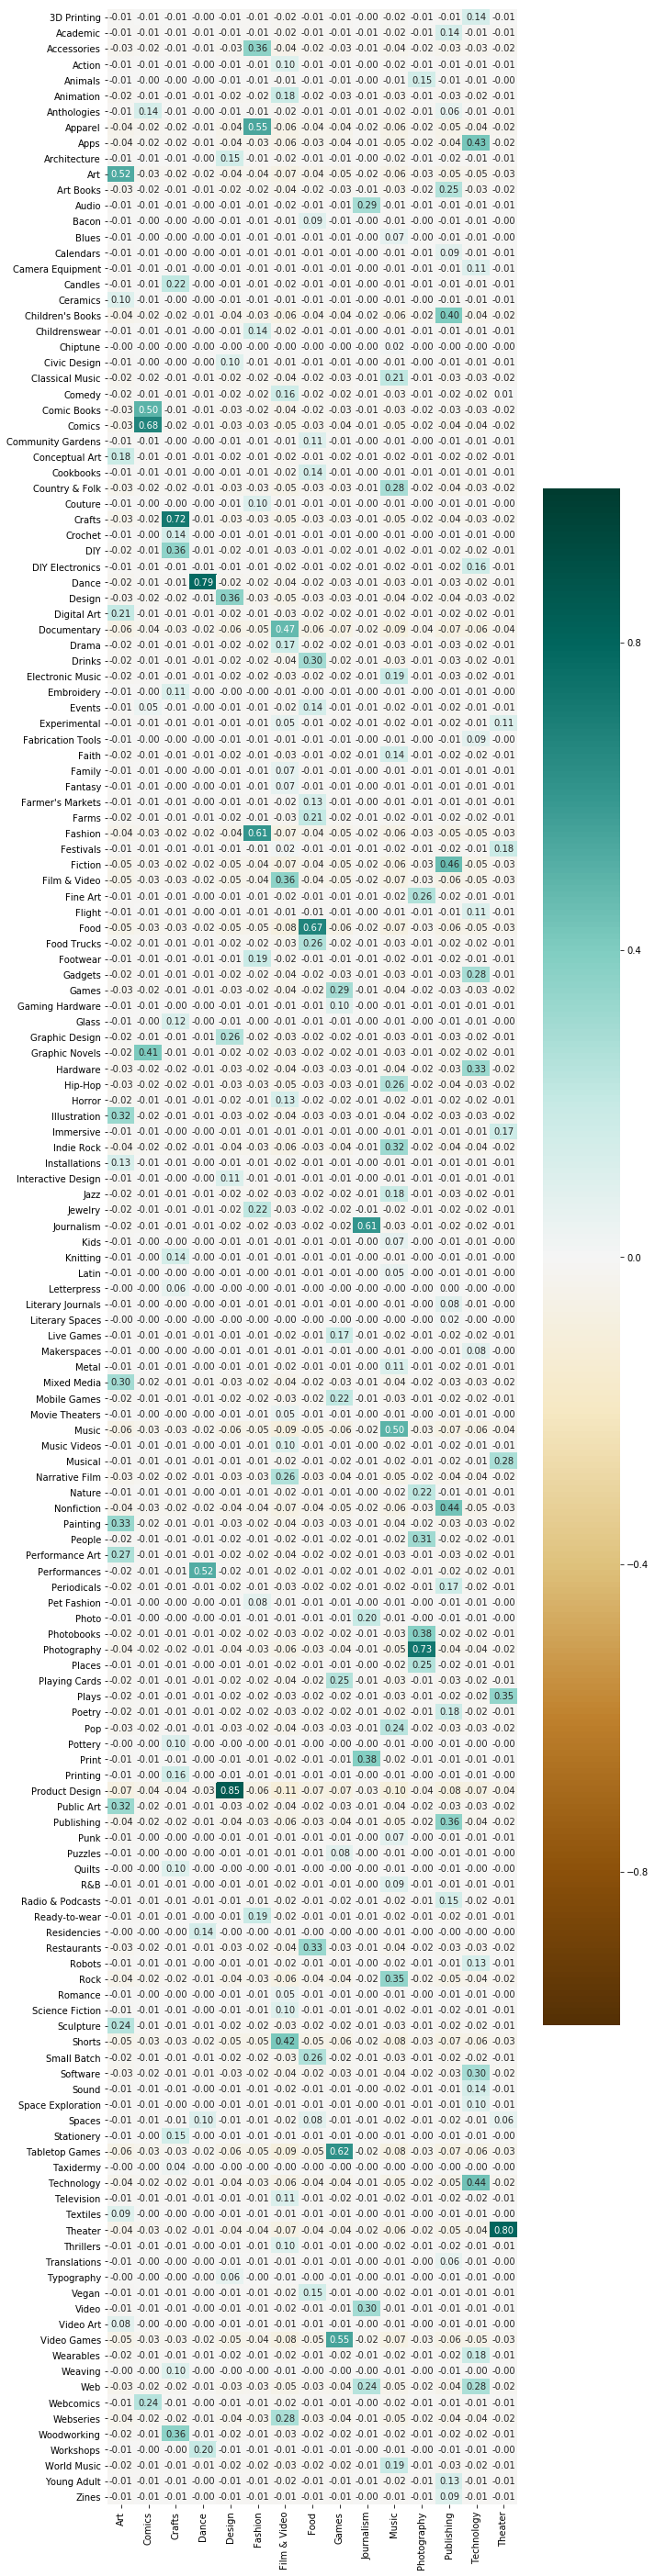

In [144]:
main_category = pd.get_dummies(df_kstart["main_category"]).fillna(0)
category = pd.get_dummies(df_kstart["category"]).fillna(0)
corr1 = my_corr(category, main_category)
plt.figure(figsize=(10, 50))
print("相関係数")
sns.heatmap(corr1, vmax=1, vmin=-1, center=0, annot=True, fmt='.2f', linecolor='white', cmap="BrBG")
print("関係性はありそうなのでもっと詳しく見ていく\n")

In [145]:
unique_category = df_kstart.groupby("category")["main_category"]

print("対応表")
print("ほとんどの category が main_category を一意に定めることができそう\n")
print(unique_category.unique())

norm_unique_category = unique_category.value_counts(normalize=True)
unique_category = unique_category.value_counts()
#display(norm_unique_category.unstack(fill_value=0))

対応表
ほとんどの category が main_category を一意に定めることができそう

category
3D Printing                                        [Technology]
Academic                                           [Publishing]
Accessories                                           [Fashion]
Action                                           [Film & Video]
Animals                                           [Photography]
Animation                                        [Film & Video]
Anthologies                                [Comics, Publishing]
Apparel                                               [Fashion]
Apps                                               [Technology]
Architecture                                           [Design]
Art                                                       [Art]
Art Books                                          [Publishing]
Audio                                              [Journalism]
Bacon                                                    [Food]
Blues                                       

In [146]:
index1 = unique_category[norm_unique_category < 1].keys()
multi_category = unique_category[index1]
print("main_category を一意に定めることができない category\n")
print(multi_category)
print("\n総数: {}".format(multi_category.sum()))
print("割合: {:.2f}%".format(multi_category.sum() / len(df_kstart) * 100))
print("約97%の category が一意に main_category を定めることができる\nmain_category :除外候補")
#print(unique_category.unique()[unique_category.nunique()>1]).keys()
#unique_category.value_counts()

main_category を一意に定めることができない category

category      main_category
Anthologies   Comics            386
              Publishing        351
Comedy        Film & Video     1893
              Theater            92
              Publishing         66
              Music              17
Events        Food              567
              Comics            140
Experimental  Film & Video      480
              Theater           342
Festivals     Theater           512
              Film & Video      263
Letterpress   Crafts             36
              Publishing         10
Spaces        Food              383
              Theater           194
              Dance             178
Web           Technology       3237
              Journalism       1072
Name: main_category, dtype: int64

総数: 10219
割合: 3.08%
約97%の category が一意に main_category を定めることができる
main_category :除外候補


### [country] と [currency] の関係

相関係数
country から currency を一意に定めることができそうだ



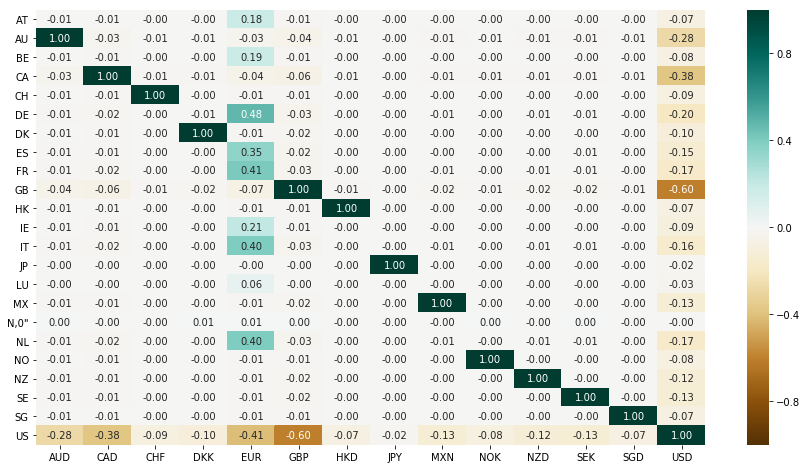

In [147]:
country = pd.get_dummies(df_kstart["country"]).fillna(0)
currency = pd.get_dummies(df_kstart["currency"]).fillna(0)
corr2 = my_corr(country, currency)
plt.figure(figsize=(15, 8))
print("相関係数")
print("country から currency を一意に定めることができそうだ\n")
sns.heatmap(corr2, vmax=1, vmin=-1, center=0, annot=True, fmt='.2f', linecolor='white', cmap="BrBG")

In [148]:
unique_country = df_kstart.groupby("country")["currency"]

print("対応表")
print("N,0 を除けば country から currency が決まる\n")
print(unique_country.unique())

norm_unique_country = unique_country.value_counts(normalize=True)
unique_country = unique_country.value_counts()
#norm_unique_country.unstack(fill_value=0)

対応表
N,0 を除けば country から currency が決まる

country
AT                                         [EUR]
AU                                         [AUD]
BE                                         [EUR]
CA                                         [CAD]
CH                                         [CHF]
DE                                         [EUR]
DK                                         [DKK]
ES                                         [EUR]
FR                                         [EUR]
GB                                         [GBP]
HK                                         [HKD]
IE                                         [EUR]
IT                                         [EUR]
JP                                         [JPY]
LU                                         [EUR]
MX                                         [MXN]
N,0"    [USD, GBP, CAD, EUR, NOK, DKK, SEK, AUD]
NL                                         [EUR]
NO                                         [NOK]
NZ                    

In [149]:
index2 = unique_country[norm_unique_country < 1].keys()
multi_country = unique_country[index2]
print("N,0 の詳細\n")
print(multi_country)
print("\n総数: {}".format(multi_country.sum()))
print("割合: {:.2f}%".format(multi_country.sum() / len(df_kstart) * 100))
print("約100%の country が一意に currency を定めることができる\ncurrency :除外候補")
#print(unique_category.unique()[unique_category.nunique()>1]).keys()
#unique_category.value_counts()

N,0 の詳細

country  currency
N,0"     USD         151
         GBP          22
         EUR          21
         AUD           5
         CAD           5
         DKK           3
         NOK           2
         SEK           1
Name: currency, dtype: int64

総数: 210
割合: 0.06%
約100%の country が一意に currency を定めることができる
currency :除外候補


## 日付について
開始/終了した年月日によって成否が変わるかもしれないので確認


In [0]:
def get_date_dummies(df, columns):
  for column in columns:
    df[column+"_year"] = df[column].dt.year
    df[column+"_month"] = df[column].dt.month
    df[column+"_day"] = df[column].dt.day
    df = df.drop(columns=column)
  return df

def drop_date_dummies(df, columns):
  for column in columns:
    df = df.drop(columns=[column+"_year", column+"_month", column+"_day"])
  return df

In [0]:
df_kstart = get_date_dummies(df_kstart, columns=["deadline", "launched"])

[deadline_year],[launched_year] に関係ありそうだが、過去の年データは予測に不要なので考慮しない
[deadline],[launched] :除外候補



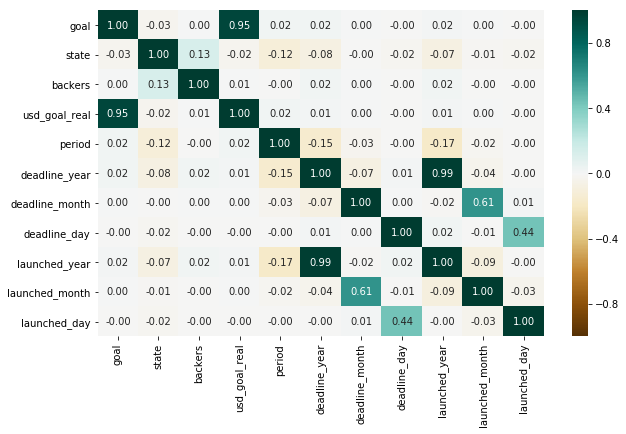

In [152]:
print("[deadline_year],[launched_year] に関係はありそうだが、過去の年データは予測に不要なので考慮しない")
print("[deadline],[launched] :除外候補\n")
plt.figure(figsize=(10, 6))
sns.heatmap(df_kstart.corr(), vmax=1, vmin=-1, center=0, annot=True, fmt='.2f', linecolor='white', cmap="BrBG")

# データの前処理


### データの除外
除外候補の [country], [main_category], [deadline], [launched] を除外

In [0]:
df_kstart = df_kstart.drop(columns=["usd_goal_real", "main_category", "currency"])
df_kstart = drop_date_dummies(df_kstart, columns=["deadline", "launched"])

In [0]:
df_kstart = pd.get_dummies(df_kstart, columns=["category"]).fillna(0)
df_kstart = pd.get_dummies(df_kstart, columns=["country"]).fillna(0)

## 正規化、標準化
今回はそのままで計算してみる

In [0]:
pass

# 特徴量の設計・抽出

In [0]:
# グラフから検討
pass

# モデルの検討
今回は二項分類なので SGDClassifier を採用

In [0]:
Y = df_kstart["state"].values
x = df_kstart.drop(columns=["state"])
X = x.values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

In [0]:
def run_evaluation(epoch, X_train, X_test, Y_train, Y_test):
  clf = SGDClassifier(loss="log", penalty="none", max_iter=epoch, fit_intercept=True, random_state=1111)
  clf.fit(X_train, Y_train)

  Y_est = clf.predict(X_test)
  
  #print("対数尤度 = {:.3f}".format(- log_loss(Y_test, Y_est)))
  
  accuracy = accuracy_score(Y_test, Y_est) * 100
  precision = precision_score(Y_test, Y_est)* 100
  recall = recall_score(Y_test, Y_est)* 100
  f1 = f1_score(Y_test, Y_est)* 100
  roc_auc = roc_auc_score(Y_test, Y_est)* 100
  
  #print("正答率 = {:.3f}%".format(accuracy)
  #print("適合率 = {:.3f}%".format(precision)
  #print("再現率 = {:.3f}%".format(recall)
  #print("Ｆ－１ = {:.3f}%".format(f1)
  #print("ＡＵＣ = {:.3f}%".format(roc_auc)

  #conf_mat = pd.DataFrame(confusion_matrix(Y_test, Y_est), 
  #                        index=["Actual : failed", "Actual : successful"], 
  #                        columns=["Predict : failed", "Predict : successful"])
  #display(conf_mat)
  
  #return clf.coef_[0]
  return accuracy, precision, recall, f1, roc_auc

# モデルの評価

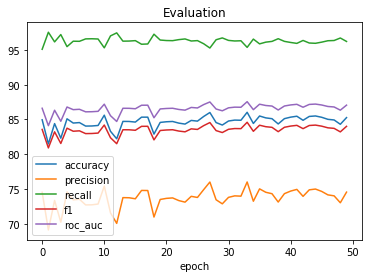

In [279]:
import warnings
warnings.filterwarnings('ignore')

epoch = 50

accuracy_list = [None] * epoch
precision_list = [None] * epoch
recall_list = [None] * epoch
f1_list = [None] * epoch
roc_auc_list = [None] * epoch

x = range(epoch)

for i in x:
  accuracy, precision, recall, f1, roc_auc = run_evaluation(i+1, X_train, X_test, Y_train, Y_test)
  accuracy_list[i] = accuracy
  precision_list[i] = precision
  recall_list[i] = recall
  f1_list[i] = f1
  roc_auc_list[i] = roc_auc

plt.plot(x, accuracy_list, label='accuracy')
plt.plot(x, precision_list, label='precision')
plt.plot(x, recall_list, label='recall')
plt.plot(x, f1_list, label='f1')
plt.plot(x, roc_auc_list, label='roc_auc')
plt.legend(loc='best')


plt.title("Evaluation")
plt.xlabel("epoch")

#acc = plt.plot(x, accuracy_list)
#pre = plt.plot(x, precision_list)
#rec = plt.plot(x, recall_list)
#f1_ = plt.plot(x, f1_list)
#auc = plt.plot(x, roc_auc_list)
#plt.legend((acc, pre, rec, f1_, auc), ("accuracy", "precision", "recall", "f1", "roc_auc"), loc=2)
plt.show()


In [248]:
df_result = get_top(coef, 10)

df_result.index = df_result.index + 1
df_result.columns.name = "TOP{}_Weight".format(top)
display(df_result)

TOP10_Weight,Weight,key
1,1.887662e+06,backers
2,2.519081e+04,period
3,7.671548e+03,goal
4,4.709792e+02,country_GB
5,3.455849e+02,category_Video Games
6,2.720232e+02,category_Documentary
7,2.524207e+02,category_Shorts
8,2.443385e+02,category_Music
9,2.079219e+02,category_Fiction
10,2.074007e+02,category_Theater


In [249]:
df_result = get_top(conf, 10, bottom=True)

df_result.index = df_result.index + 1
df_result.columns.name = "TOP{}_Weight".format(top)
display(df_result)

TOP10_Weight,Weight,key
1,-0.032756,category_Animation
2,-0.107680,category_Couture
3,-0.253859,category_Taxidermy
4,-0.266192,category_Literary Spaces
5,-0.343599,country_LU
6,-0.419381,category_Family
7,-0.448696,category_Makerspaces
8,-0.485533,category_Letterpress
9,-0.524904,category_Latin
10,-0.545093,category_Pottery


In [0]:
def get_top(coef_, n, bottom=False):
  top = n
  weights = np.abs(coef_)
  if(bottom):
    weights *= -1

  weights_top_index = np.argpartition(-weights, top)[:top]

  keys = x.keys()
  result = {}

  for index in weights_top_index:
    result[weights[index]] = keys[index]

  return pd.DataFrame(sorted(result.items(), reverse=True), columns=["Weight", "key"])

# モデルのチューニング

# 結果から検討

max_iter 数が変わってもあまり違いがなさそう<br>
他のハイパーパラメータを調整したい

# モデルの決定

In [0]:
# 保存

# 新しいデータを取得

In [0]:
# あらかじめデータを分割しておく
# または適当に作る

# 学習済みモデルの更新

In [0]:
# モデルにパラメータの割り当て？

# 予測

In [0]:
# x.shape(None, x...)
# y = model(x)

# 結果の評価

In [0]:
# loss = y.loss()
# accuracy = y.accuracy()